До этого мы в основном смотрели на модели дли одного ряда — локальные модели (ARIMA, ETS). Сейчас у нас **много рядов в одном датасете**, и мы будем:
- обучать **одну глобальную ML-модель** на всех рядах сразу;
- строить прогноз **по каждому ряду** из датасета;
- обсуждать препроцессинг, feature engineering и валидацию именно в этом сеттинге.

План ноутбука:
1. Данные и переход из long формата данных в wide.
2. Препроцессинг для ML-моделей на временных рядах.
3. Feature engineering (календарные признаки, лаги, скользящие статистики, Фурье, Вейвлеты).
4. Валидация со скользящим и расширяющимся окном, бэктестинг.
5. Построение одношаговой глобальной ML-модели для всех рядов сразу.

In [86]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

try:
    import statsmodels.api as sm

    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Данные и переход из long формата данных в wide

Будем работать со сгенерированным датасетом, состоящим из нескольких временных рядов.

Структура **long формата** данных:
- `series_id` — идентификатор временного ряда;
- `ds` — дата;
- `y` — значение временного ряда в дату `ds`.
- Если есть, то внешние признаки.

In [87]:
def make_synthetic_panel(
    n_series: int = 20,
    n_periods: int = 300,
    freq: str = "D",
) -> pd.DataFrame:
    """Создает синтетический датасет с несколькими временными рядами в long формате (тренд + сезонность + шум)."""
    idx = pd.date_range("2020-01-01", periods=n_periods, freq=freq)
    rows = []
    rng = np.random.default_rng(RANDOM_STATE)

    for series_id in range(n_series):
        level = rng.normal(loc=10, scale=5)
        trend = rng.normal(loc=0.01, scale=0.02)
        seasonal_amplitude = rng.uniform(2, 5)
        noise = rng.normal(loc=0, scale=1, size=n_periods)

        t = np.arange(n_periods)
        # Недельная синусовая сезонность
        seasonal = seasonal_amplitude * np.sin(2 * np.pi * t / 7)
        y = level + trend * t + seasonal + noise

        rows.append(pd.DataFrame({"series_id": series_id, "ds": idx, "y": y}))

    return pd.concat(rows, ignore_index=True)


df_long = make_synthetic_panel()

print("First 5 rows of the long format dataset:")
display(df_long.head())

print("Last 5 rows of the long format dataset:")
display(df_long.tail())

print("Subset with series_id = 0:")
display(df_long[df_long["series_id"] == 0])

First 5 rows of the long format dataset:


,series_id,ds,y
0,0,2020-01-01,12.464150
1,0,2020-01-02,13.139250
2,0,2020-01-03,14.660876
3,0,2020-01-04,13.604389
4,0,2020-01-05,9.178782


Last 5 rows of the long format dataset:


,series_id,ds,y
5995,19,2020-10-22,16.389005
5996,19,2020-10-23,15.677798
5997,19,2020-10-24,13.907823
5998,19,2020-10-25,12.703216
5999,19,2020-10-26,12.783372


Subset with series_id = 0:


,series_id,ds,y
0,0,2020-01-01,12.464150
1,0,2020-01-02,13.139250
2,0,2020-01-03,14.660876
3,0,2020-01-04,13.604389
4,0,2020-01-05,9.178782
...,...,...,...
295,0,2020-10-22,10.158457
296,0,2020-10-23,13.115944
297,0,2020-10-24,12.028793
298,0,2020-10-25,4.786056


Обратите внимание, что ряды выровнены — у всех рядов одинаковые даты начала и конца, нет пропусков внутри рядов.

In [88]:
print("Ряды выровнены по датам, не имеют пропусков и имеют одинаковую длину:")
display(df_long.groupby("series_id")["ds"].agg(["min", "max", "count"]))

Ряды выровнены по датам, не имеют пропусков и имеют одинаковую длину:


,min,max,count
series_id,,,
0,2020-01-01,2020-10-26,300
1,2020-01-01,2020-10-26,300
2,2020-01-01,2020-10-26,300
3,2020-01-01,2020-10-26,300
4,2020-01-01,2020-10-26,300
5,2020-01-01,2020-10-26,300
6,2020-01-01,2020-10-26,300
7,2020-01-01,2020-10-26,300
8,2020-01-01,2020-10-26,300


Посмотрим на несколько рядов:

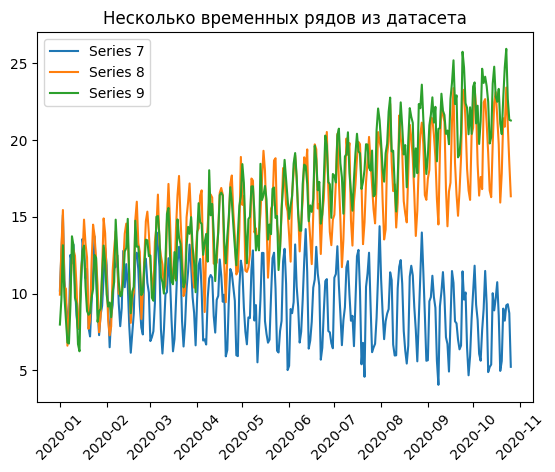

In [89]:
sample_ids = df_long["series_id"].unique()[7:10]

for series_id in sample_ids:
    series_data = df_long[df_long["series_id"] == series_id]
    plt.plot(series_data["ds"], series_data["y"], label=f"Series {series_id}")

plt.title("Несколько временных рядов из датасета")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Структура **long формата** данных:
- `ds` — базовая дата (например, дата прогноза / дата последнего известного наблюдения);
- Наблюдения (лаговые признаки);
- Внешние признаки (если есть);
- Целевая переменная `y`. В случае прогноза на `h` шагов вперед — значения `y` на следующие `h` шагов.

В каждой строке — информация о каком-то кусочке определенного ряда на определенную базовую дату.

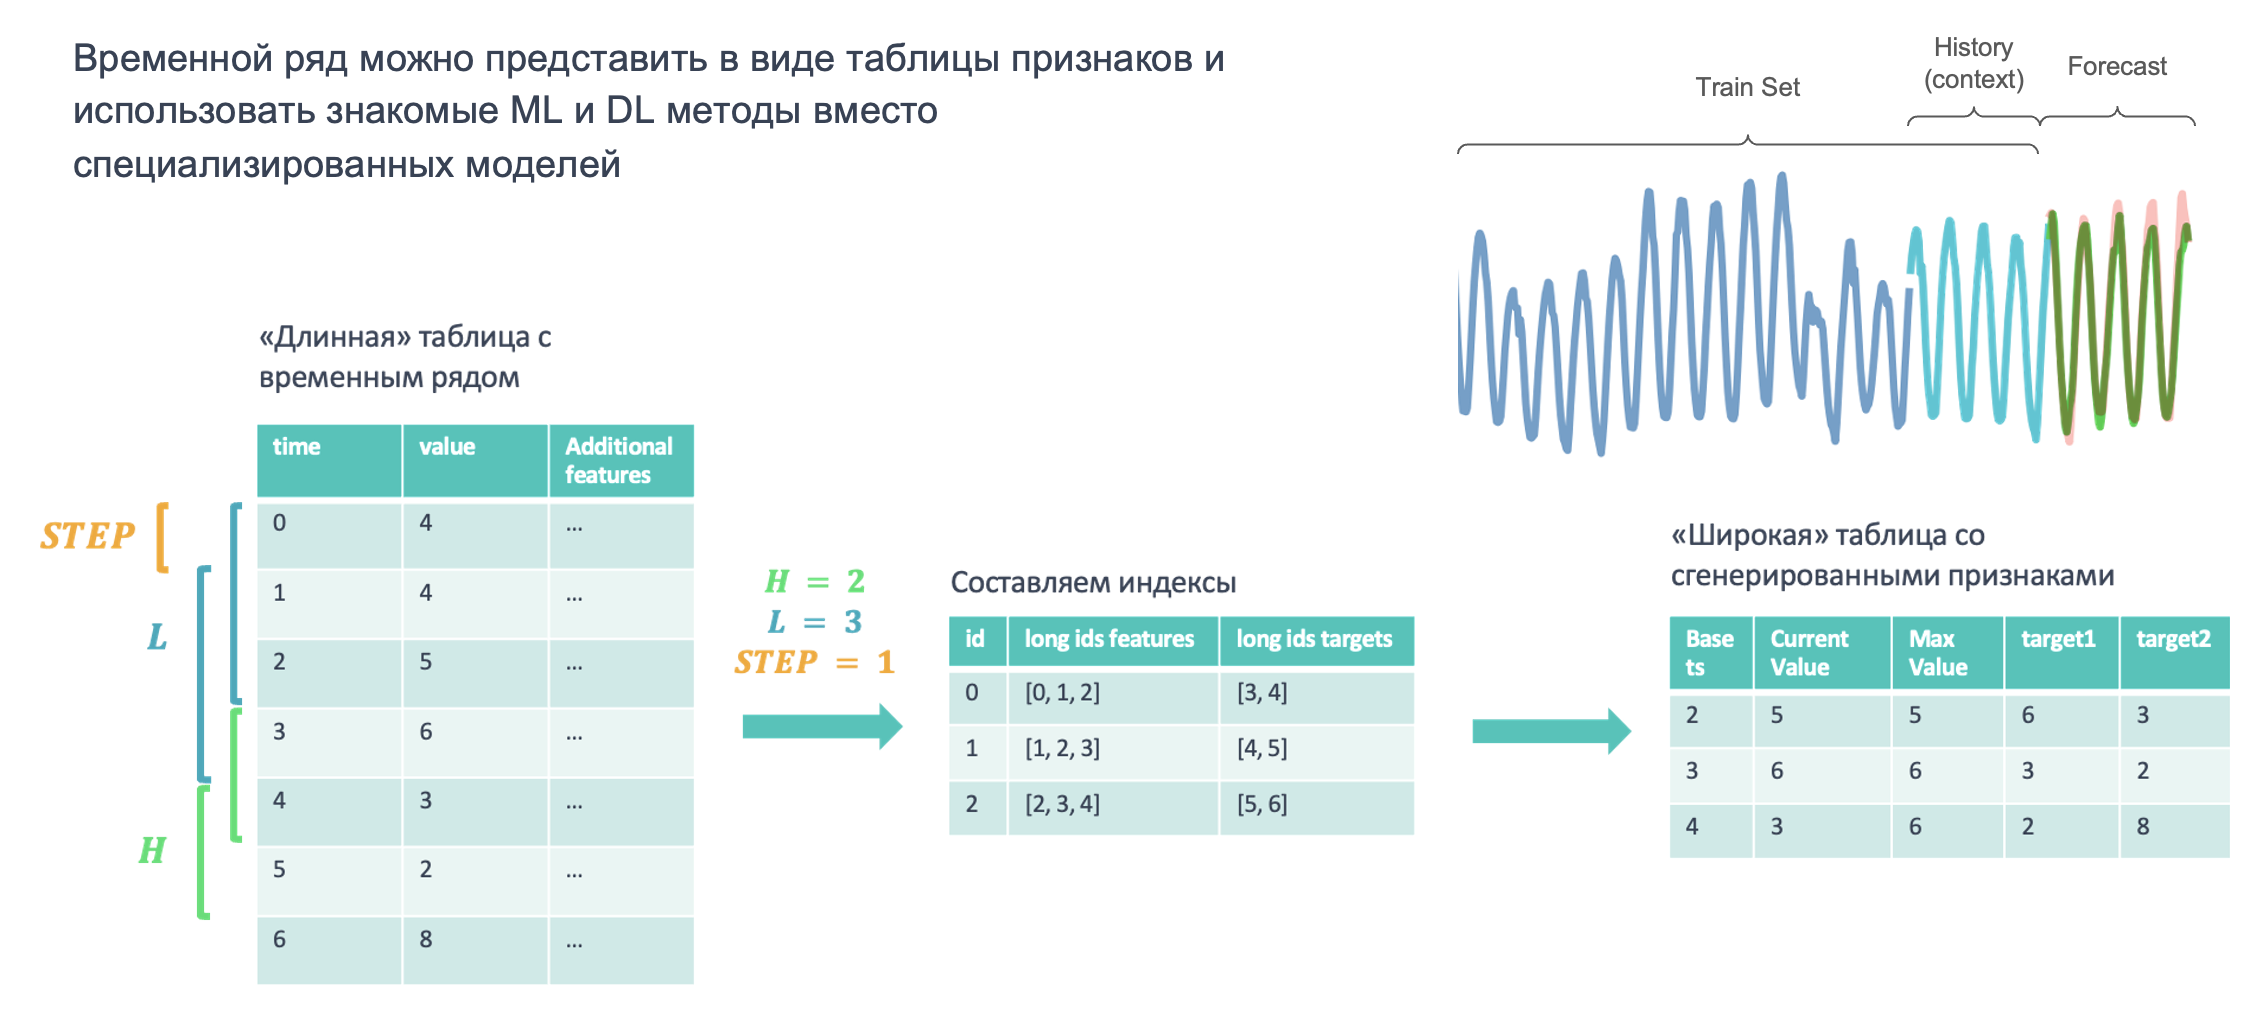

Один из видов представления датасета в таком формате — это таблица, где строки соответствуют отдельным отметкам времени, а столбцы — точкам во временных рядах. Это multivariate формат данных.

В этом случае мы ожидаем прогноз как бы вниз по столбцам, то есть для каждой точки во временном ряде мы хотим предсказать несколько будущих отметок времени.

Подобное представление активно используется, например, при обучении нейронных сетей в сообществе исследователей. 

In [90]:
def long_to_wide(
    df: pd.DataFrame,
    index_col: str = "ds",
    series_col: str = "series_id",
    target_col: str = "y",
) -> pd.DataFrame:
    return df.pivot(index=index_col, columns=series_col, values=target_col)


df_wide = long_to_wide(df_long)
df_wide.head()

series_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ds,,,,,,,,,,,,,,,,,,,,
2020-01-01,12.464150,8.022918,14.352667,5.174356,7.692207,10.736282,13.189148,10.193067,9.927835,7.982636,9.857956,7.765760,7.335988,16.564442,4.730086,10.242650,6.111026,10.244815,7.647619,11.470009
2020-01-02,13.139250,12.838262,15.237121,6.525255,9.053143,11.844188,17.227143,12.575412,12.959955,9.637039,12.954982,11.274315,10.601482,20.962224,8.327735,12.847505,10.089560,11.636449,9.730473,11.478766
2020-01-03,14.660876,12.913083,17.127762,8.755561,9.053731,13.181046,17.539120,15.117859,15.434013,13.142937,12.949867,10.400801,14.708076,22.211119,9.438111,15.507885,6.728129,12.596372,10.696683,10.786831
2020-01-04,13.604389,11.876372,13.800680,7.167265,8.859757,9.804789,13.541769,10.881541,10.434295,9.795955,11.003482,7.951050,10.610161,18.967239,5.979474,11.297141,7.068937,11.730327,8.500311,12.054987
2020-01-05,9.178782,7.809514,12.983907,4.628847,9.380375,9.284240,11.125690,9.415867,10.309186,8.348335,8.191461,6.175774,6.273301,17.180745,4.337663,7.241693,6.606004,7.383684,4.792545,7.757532


Покажем соответствие графически: один и тот же временной ряд в long и wide форматах.

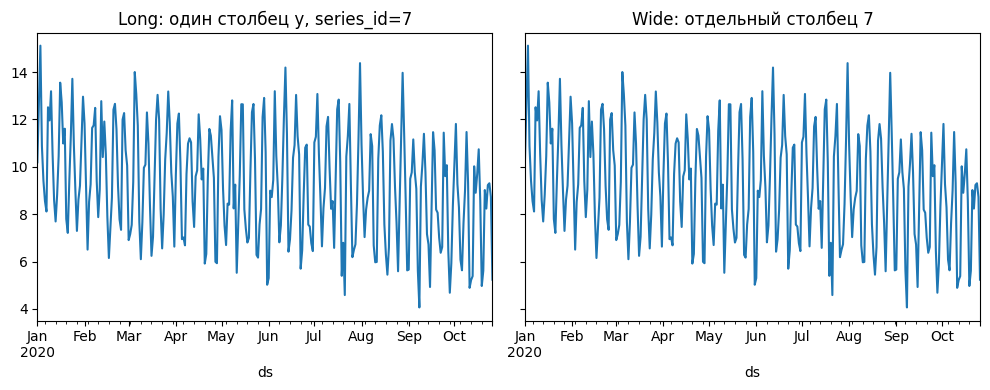

In [91]:
sample_id = sample_ids[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

df_long.query("series_id == @sample_id").set_index("ds")["y"].plot(ax=axes[0], title="Long format")
axes[0].set_title(f"Long: один столбец y, series_id={sample_id}")

df_wide[sample_id].plot(ax=axes[1])
axes[1].set_title(f"Wide: отдельный столбец {sample_id}")

plt.tight_layout()
plt.show()

В другом вариаенте мы можем представить данные в виде таблицы, где каждая строка соответствует признакам, которые должны помочь предсказать продолжение ряда из конкретной точки. Среди этих признаков могут быть как сами отметки временного ряда из прошлого, так и идентификаторы временных рядов, признаки из дат, внешние признаки. Это global формат данных.

В этом случае мы ожидаем прогноз как бы вправо по строкам, то есть для каждой строки мы хотим предсказать продолжение временного ряда, соответствующего этой строке. 

Это представление приближенно к обычной постановке машинного обучения, где у нас есть признаки и целевая переменная (здесь, правда, целевая переменная — это сразу несколько будущих отметок временного ряда).

In [92]:
def long_to_wide__global(
    df: pd.DataFrame,
    index_col: str = "ds",
    series_col: str = "series_id",
    target_col: str = "y",
    history_size: int = 5,
) -> pd.DataFrame:
    rows = []
    series_ids = df[series_col].unique()

    for series_id in series_ids:
        series_data = df[df[series_col] == series_id].reset_index(drop=True)

        for i in range(history_size, len(series_data)):
            history = series_data.loc[i - history_size : i - 1, target_col].values
            target = series_data.loc[i, target_col]
            ds = series_data.loc[i, index_col]

            row = {f"lag_{j+1}": history[j] for j in range(history_size)}
            row.update({series_col: series_id, index_col: ds, target_col: target})
            rows.append(row)

    return pd.DataFrame(rows)


df_wide_global = long_to_wide__global(df_long, history_size=5)
df_wide_global.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,series_id,ds,y
0,12.464150,13.139250,14.660876,13.604389,9.178782,0,2020-01-06,6.991717
1,13.139250,14.660876,13.604389,9.178782,6.991717,0,2020-01-07,7.028244
2,14.660876,13.604389,9.178782,6.991717,7.028244,0,2020-01-08,12.327386
3,13.604389,9.178782,6.991717,7.028244,12.327386,0,2020-01-09,15.792479
4,9.178782,6.991717,7.028244,12.327386,15.792479,0,2020-01-10,15.953488


Обратите внимание, что мы можем вытащить дополнительные признаки из колонки `ds`. А также не забывайте, что `y` — это таргет, а не признак.

## 2. Препроцессинг для ML-моделей на временных рядах

- Есть модели, **чувствительные к масштабу признаков** (например, линейная регрессия, kNN, нейронные сети). Для них полезно стандартизовать признаки.
- Есть модели, **инвариантные к монотонным преобразованиям масштаба** (например, деревья решений, случайный лес, градиентный бустинг). StandardScaler для них не обязателен. Но им все равно важны формы распределений признаков, поэтому полезно использовать логарифмирование, дифференцирование, клиппинг выбросов, удаление тренда.

К примеру, если ряд содержит тренд, а мы подаем лаговые признаки в бустинг и пытаемся на этом его обучить, то он может не справиться, так как деревянные модели плохо экстраполируют. В этом случае может помочь добавление дифференцированных признаков, а не просто лагов исходного ряда. 

In [93]:
df_long = df_long.sort_values(by=["series_id", "ds"]).copy()

# Лог-преобразование (добавочный признак)
df_long["y_log"] = np.log1p(df_long["y"] - df_long["y"].min() + 1.0)

# Обязательно нужно сделать shift, чтобы не было "заглядывания в будущее"
df_long["y_log"] = df_long.groupby("series_id")["y_log"].shift(1)

# Разность по ряду — как отдельный признак (НЕ новый таргет)
# Обязательно нужно сделать shift, чтобы не было "заглядывания в будущее"
df_long["y_diff1"] = df_long.groupby("series_id")["y"].shift(1).diff()

df_long.head()

,series_id,ds,y,y_log,y_diff1
0,0,2020-01-01,12.464150,NaN,NaN
1,0,2020-01-02,13.139250,3.119108,NaN
2,0,2020-01-03,14.660876,3.148509,0.675100
3,0,2020-01-04,13.604389,3.211767,1.521625
4,0,2020-01-05,9.178782,3.168274,-1.056486


## 3. Feature engineering

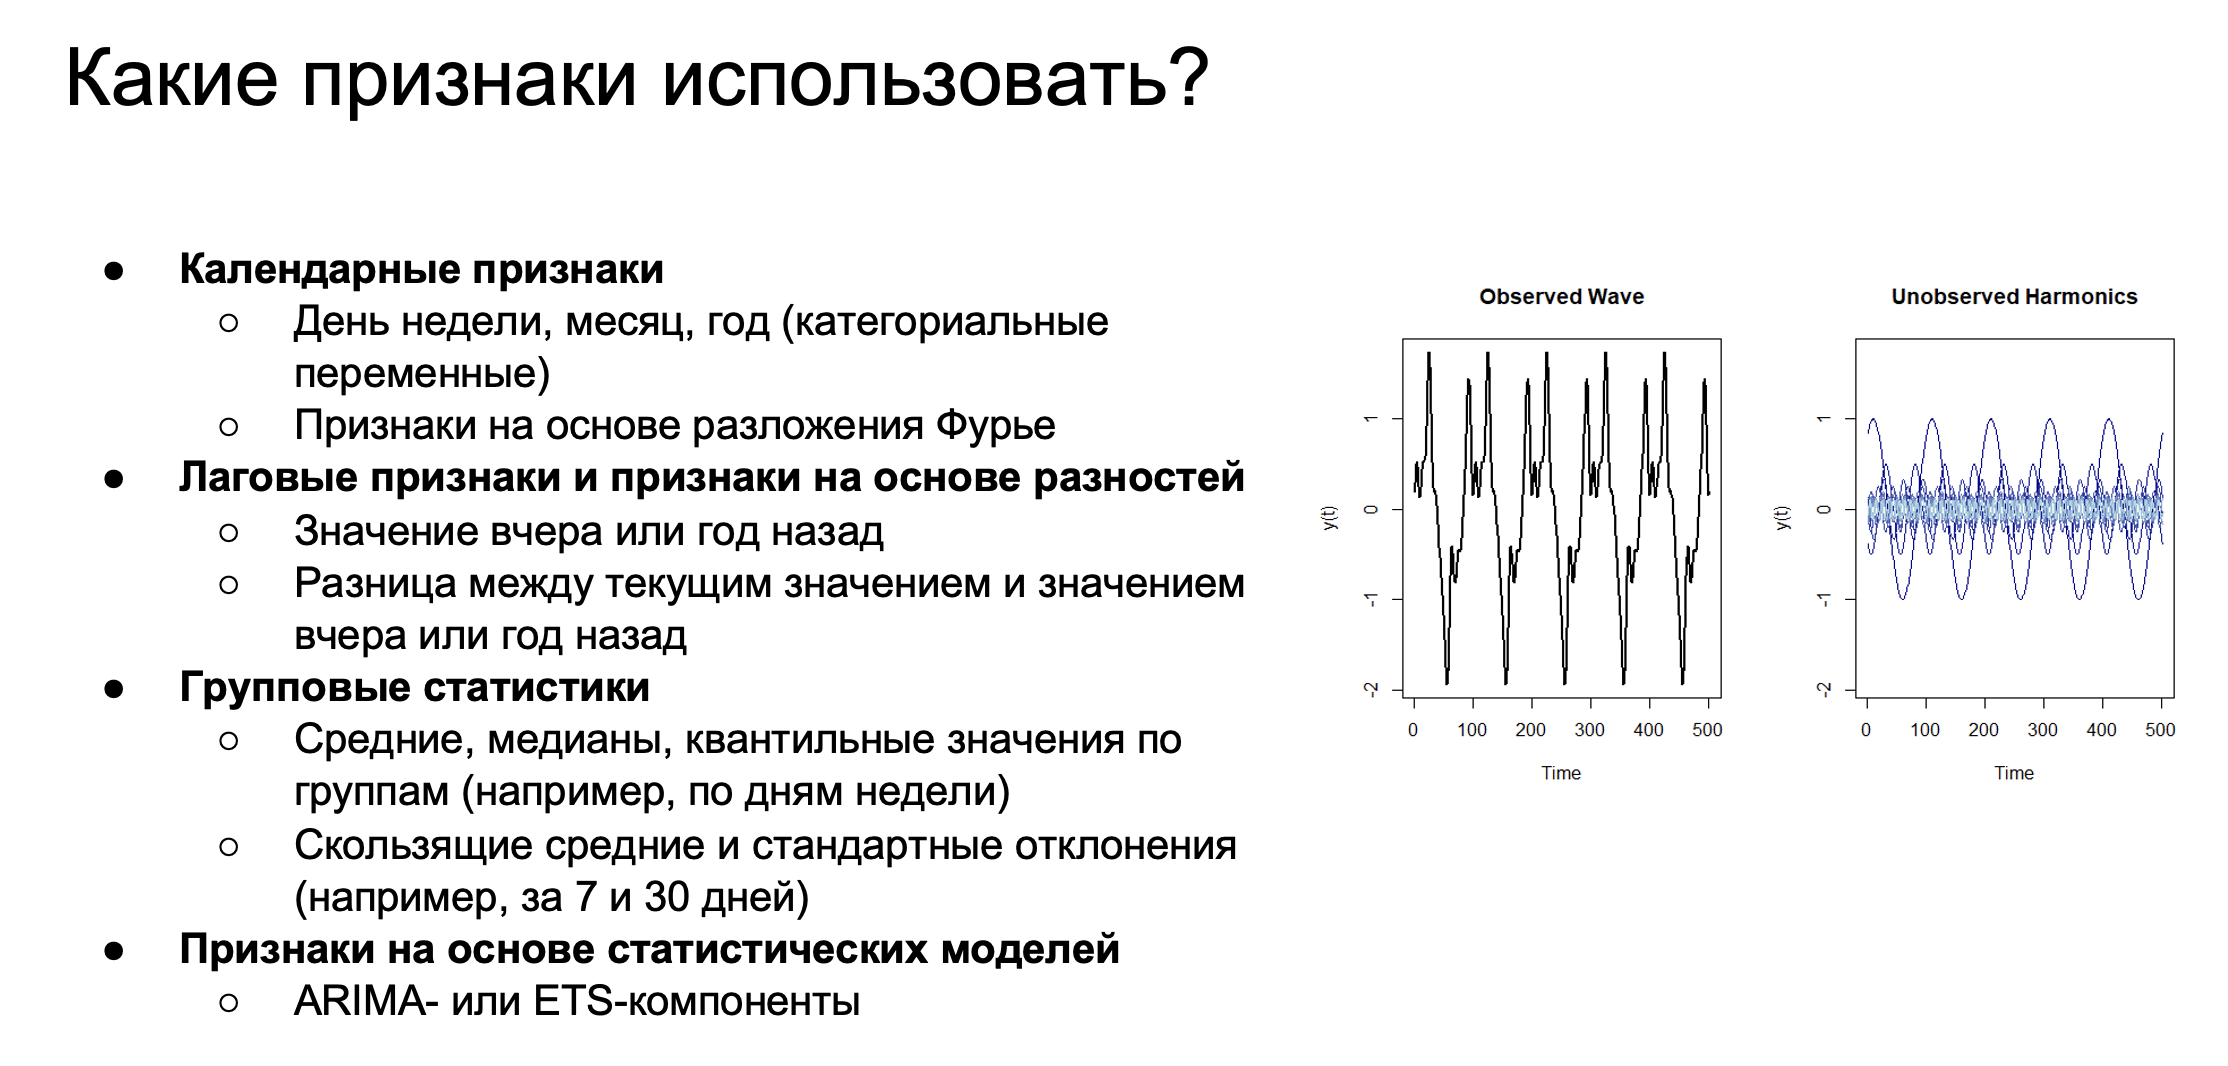

Основные признаки, которые сейчас будем строить:
- календарные признаки (год, месяц, день, день недели, выходной);
- лаги и оконные статистики (rolling mean / std);
- Fourier-признаки для моделирования сезонности;
- Wavelet-признаки.

Обратите внимание на опасность утечки данных:
- любой прогноз в момент времени `t` может использовать информацию только из `t-1, t-2, ...`;
- нельзя использовать значения из будущего, если хотим делать честный прогноз.

In [94]:
def add_time_features(df: pd.DataFrame, time_col: str = "ds") -> pd.DataFrame:
    """
    Календарные признаки для временной колонки.
    """
    out = df.copy()
    dt = pd.to_datetime(out[time_col])

    out["year"] = dt.dt.year
    out["month"] = dt.dt.month
    out["day"] = dt.dt.day
    out["dow"] = dt.dt.dayofweek
    out["weekofyear"] = dt.dt.isocalendar().week.astype(int)
    out["is_weekend"] = (out["dow"] >= 5).astype(int)

    return out


def add_lag_features(
    df: pd.DataFrame,
    group_col: str,
    target_col: str,
    lags: List[int],
    time_col: str = "ds",
) -> pd.DataFrame:
    """
    Лаги целевой переменной. Ликов нет, если потом мы не нарушаем временной порядок при обучении модели.
    """
    out = df.copy().sort_values(by=[group_col, time_col])
    for lag in lags:
        out[f"{target_col}_lag_{lag}"] = out.groupby(group_col)[target_col].shift(lag)
    return out


def add_rolling_features(
    df: pd.DataFrame,
    group_col: str,
    target_col: str,
    windows: List[int],
    time_col: str = "ds",
) -> pd.DataFrame:
    """
    Оконные средние и std по каждому ряду.
    """
    out = df.copy().sort_values(by=[group_col, time_col])
    for window in windows:
        # Обязательно нужно сделать shift, чтобы не было "заглядывания в будущее"
        roll = out.groupby(group_col)[target_col].shift(1).rolling(window=window, min_periods=1)
        out[f"{target_col}_roll_mean_{window}"] = roll.mean().reset_index(level=0, drop=True)
        out[f"{target_col}_roll_std_{window}"] = roll.std().reset_index(level=0, drop=True)
    return out


def add_fourier_features(
    df: pd.DataFrame,
    time_col: str,
    period: int,
    order: int,
    prefix: str,
) -> pd.DataFrame:
    """
    Fourier-признаки для моделирования сезонности.
    Для простоты считаем, что шаг ~ один день.
    """
    out = df.copy()
    t0 = pd.to_datetime(out[time_col].min())
    t = (pd.to_datetime(out[time_col]) - t0).dt.total_seconds()
    seconds_per_day = 24 * 60 * 60
    x = t / (period * seconds_per_day)  # масштабирование к периодам

    for k in range(1, order + 1):
        out[f"{prefix}_sin_{k}"] = np.sin(2 * np.pi * k * x)
        out[f"{prefix}_cos_{k}"] = np.cos(2 * np.pi * k * x)

    return out


df_feat = add_time_features(df_long)
df_feat = add_lag_features(df_feat, group_col="series_id", target_col="y", lags=[1, 2, 7])
df_feat = add_rolling_features(df_feat, group_col="series_id", target_col="y", windows=[7, 28])
df_feat = add_fourier_features(df_feat, time_col="ds", period=7, order=3, prefix="dow7")

df_feat.head()

,series_id,ds,y,y_log,y_diff1,year,month,day,dow,weekofyear,...,y_roll_mean_7,y_roll_std_7,y_roll_mean_28,y_roll_std_28,dow7_sin_1,dow7_cos_1,dow7_sin_2,dow7_cos_2,dow7_sin_3,dow7_cos_3
0,0,2020-01-01,12.464150,NaN,NaN,2020,1,1,2,1,...,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0,2020-01-02,13.139250,3.119108,NaN,2020,1,2,3,1,...,12.464150,NaN,12.464150,NaN,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2,0,2020-01-03,14.660876,3.148509,0.675100,2020,1,3,4,1,...,12.801700,0.477368,12.801700,0.477368,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
3,0,2020-01-04,13.604389,3.211767,1.521625,2020,1,4,5,1,...,13.421425,1.125219,13.421425,1.125219,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
4,0,2020-01-05,9.178782,3.168274,-1.056486,2020,1,5,6,1,...,13.467166,0.923281,13.467166,0.923281,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


### Fourier features: что это вообще?

Идея:
- У нас есть **периодическая сезонность** (например, неделя = 7 дней);
- Вместо того, чтобы заводить 7 dummy-переменных `day_of_week_0`, ..., `day_of_week_6`, мы кодируем "позицию внутри периода" плавными функциями синуса и косинуса.

Для периода `P` (например, 7 дней) и порядков `k=1,2,...,K` строим признаки:

$$
sin_{k}(t) = \sin\left(2 \pi k \frac{t}{P}\right),
\quad
cos_{k}(t) = \cos\left(2 \pi k \frac{t}{P}\right).
$$

- k=1 — одна "волна" за период (гладкая сезонность);
- k=2 — две "волны" за период (более "ломаная" форма);
- комбинация нескольких пар sin/cos позволяет аппроксимировать почти любую плавную сезонность.

В ML-модели эти колонки — обычные числовые признаки.

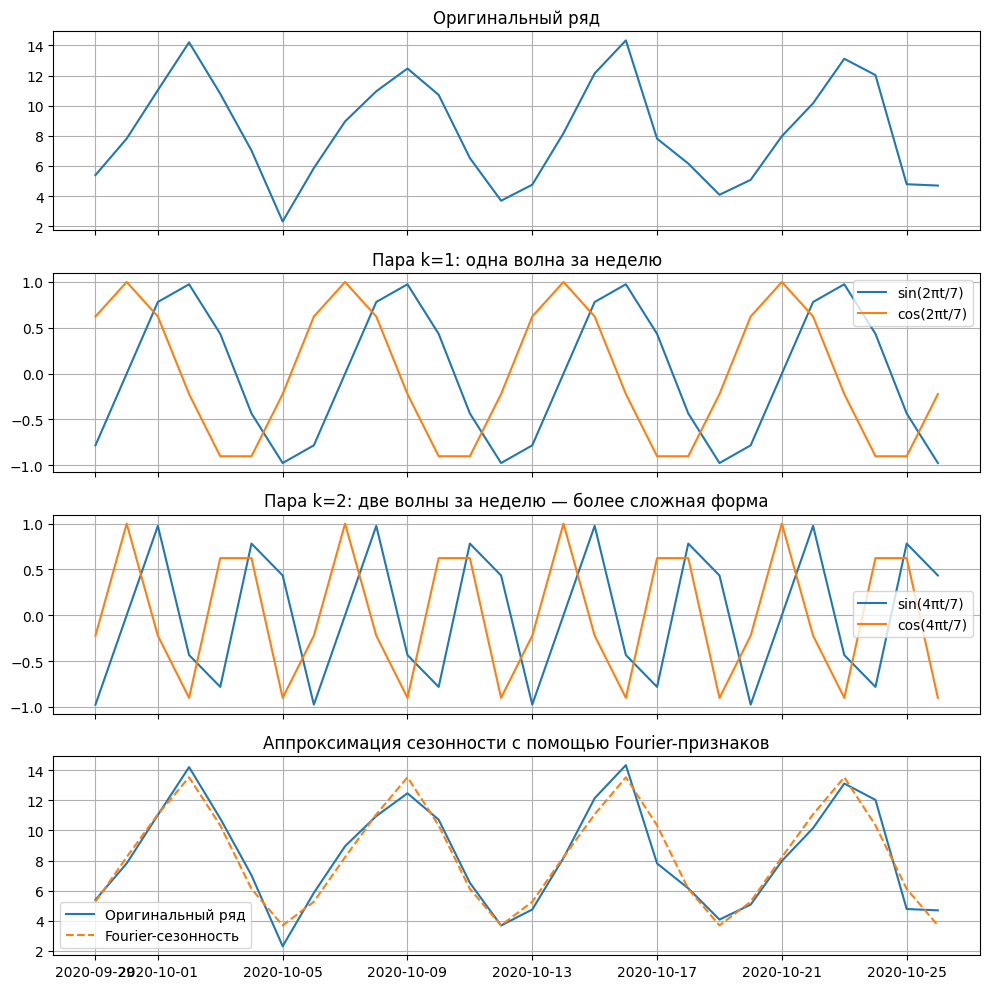

In [95]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# выберем один ряд, например, series_id = 0
series_id = 0
df_s = df_feat[df_feat["series_id"] == series_id].sort_values(by="ds").tail(7 * 4).copy()

fourier_cols = [col for col in df_s.columns if col.startswith("dow7_")]

fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# 1) исходный ряд
axes[0].plot(df_s["ds"], df_s["y"])
axes[0].set_title("Оригинальный ряд")
axes[0].grid()

# 2) Первая пара Fourier-признаков (k=1)
axes[1].plot(df_s["ds"], df_s["dow7_sin_1"], label="sin(2πt/7)")
axes[1].plot(df_s["ds"], df_s["dow7_cos_1"], label="cos(2πt/7)")
axes[1].set_title("Пара k=1: одна волна за неделю")
axes[1].legend()
axes[1].grid()

# 3) Вторая пара Fourier-признаков (k=2)
axes[2].plot(df_s["ds"], df_s["dow7_sin_2"], label="sin(4πt/7)")
axes[2].plot(df_s["ds"], df_s["dow7_cos_2"], label="cos(4πt/7)")
axes[2].set_title("Пара k=2: две волны за неделю — более сложная форма")
axes[2].legend()
axes[2].grid()

# 4) Линейная комбинация Fourier-признаков = сезонность ряда
X_fourier = df_s[fourier_cols].values
y = df_s["y"].values

lin = LinearRegression()
lin.fit(X_fourier, y)
df_s["y_hat_fourier"] = lin.predict(X_fourier)

axes[3].plot(df_s["ds"], df_s["y"], label="Оригинальный ряд")
axes[3].plot(df_s["ds"], df_s["y_hat_fourier"], label="Fourier-сезонность", linestyle="--")
axes[3].set_title("Аппроксимация сезонности с помощью Fourier-признаков")
axes[3].legend()
axes[3].grid()

plt.tight_layout()
plt.show()

In [96]:
import ipywidgets as widgets
from ipywidgets import interact

# Выберем один ряд
series_id = 0
period = 7  # недельная сезонность
n_periods = 4  # покажем последние 4 недели

df_s_full = df_feat[df_feat["series_id"] == series_id].sort_values(by="ds").copy()

df_s = df_s_full.tail(period * n_periods).copy()
y = df_s["y"].values
t = np.arange(len(df_s))  # просто индексы времени 0..N-1


def make_fourier_matrix(t, period: int, order: int):
    """
    Возвращается матрицу [N x (2*order)] и имена колонок.
    """
    cols = []
    names = []
    for k in range(1, order + 1):
        cols.append(np.sin(2 * np.pi * k * t / period))
        names.append(f"sin_{k}")
        cols.append(np.cos(2 * np.pi * k * t / period))
        names.append(f"cos_{k}")
    X = np.column_stack(cols)
    return X, names


def plot_fourier(order=1):
    order = int(order)

    X, names = make_fourier_matrix(t, period=period, order=order)
    lin = LinearRegression()
    lin.fit(X, y)
    y_hat = lin.predict(X)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # 1) Оригинальный ряд и аппроксимация
    axes[0].plot(df_s["ds"], y, label="Оригинальный ряд")
    axes[0].plot(df_s["ds"], y_hat, label=f"Fourier-аппроксимация (k={order})")
    axes[0].set_title("Ряд и его приближение первыми k гармониками")
    axes[0].legend()
    axes[0].grid()

    # 2) Сами синус/косинус признаки
    for i in range(X.shape[1]):
        axes[1].plot(df_s["ds"], X[:, i], label=names[i])
    axes[1].set_title("Используемые Fourier-признаки (синусы и косинусы)")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()


interact(
    plot_fourier,
    order=widgets.IntSlider(min=1, max=6, step=1, value=1, description="k (гармоник)"),
);

interactive(children=(IntSlider(value=1, description='k (гармоник)', max=6, min=1), Output()), _dom_classes=('…

### Wavelet features: что это вообще?

**Сравнение с Fourier:**
- Fourier-разложение ищет глобальные синусы/косинусы по всей длине ряда. Частоты есть, но где именно во времени они проявляются — не видно.
- Wavelet-разложение использует "волны" (wavelets), которые локализованы во времени (короткие "бугорки") и бывают разного масштаба (широкие/узкие, низкие/высокие частоты).

**Что нам дают wavelet-признаки:**
- можно понять, когда появляется высокочастотный шум, всплеск, скачок;
- можно вычислить энергию высокочастноных компонентов на последнем окне и использовать это как признак.

**Уровни разложения:**
- уровень A (approximation) — гладкая часть, "медленные" колебания;
- D1 — самые быстрые колебания (шум, резкие изменения);
- D2, D3, ... — промежуточные масштабы.

В ML мы часто не берем все коэффициенты по отдельности, а агрегируем их. Например, энергия деталей D1+D2+... за окно -> один числовой признак.

In [97]:
# !pip install pywavelets

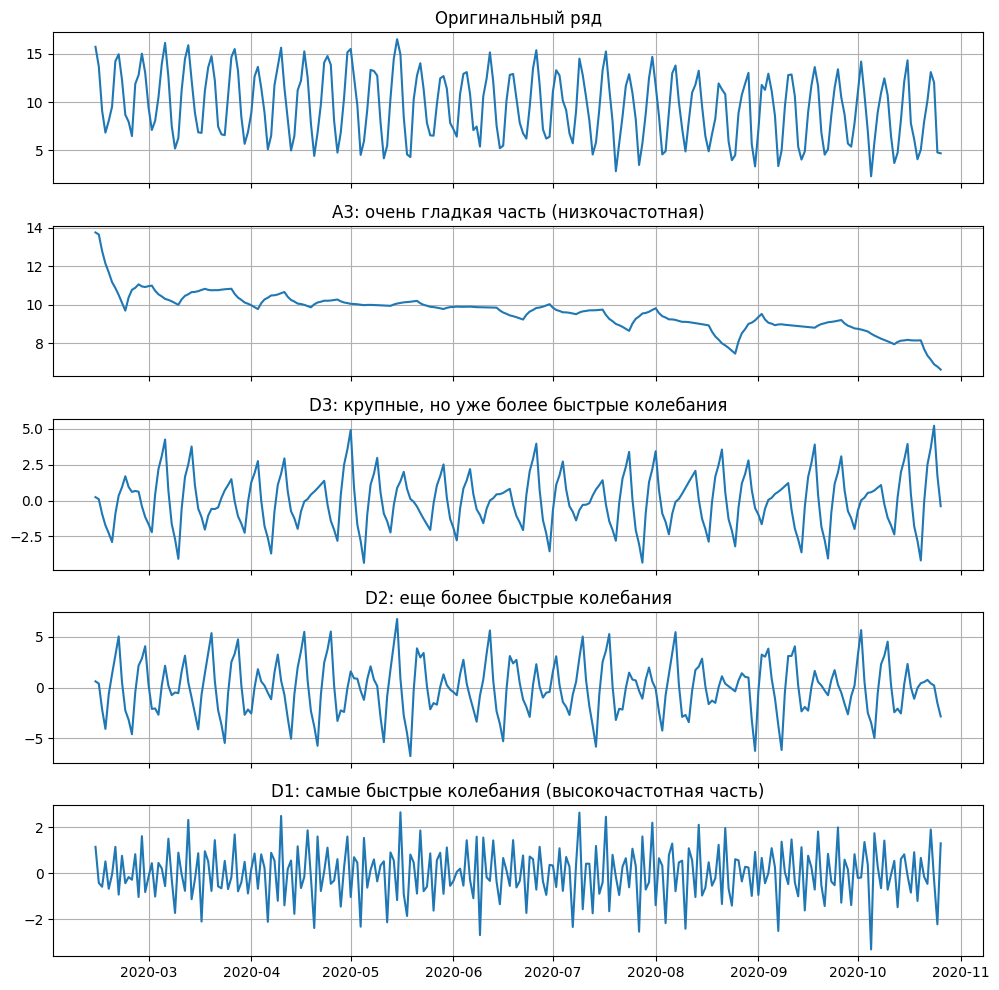

In [98]:
import pywt

# Выберем один ряд, например, series_id = 0
series_id = 0
df_s = df_feat[df_feat["series_id"] == series_id].sort_values(by="ds").copy()

# Возьмем последние N наблюдений, желательно степень двойки
N = 256
df_s = df_s.tail(N).copy()
y = df_s["y"].values

wavelet = "db2"  # Daubechies с двумя коэффициентами
level = 3  # 3 уровня разложения (A3, D3, D2, D1)

coeffs = pywt.wavedec(y, wavelet=wavelet, level=level)
# coeffs = [A3, D3, D2, D1]

def keep_only_one_component(coeffs, keep_idx: int):
    """
    Zeros out all components except the one at keep_idx.
    Index 0 = approximation (A_L), 1..L = details (D_L..D_1).
    """
    new_coeffs = []
    for i in range(len(coeffs)):
        if i == keep_idx:
            new_coeffs.append(coeffs[i])
        else:
            new_coeffs.append(np.zeros_like(coeffs[i]))
    return new_coeffs

# реконструкции
recon_A = pywt.waverec(keep_only_one_component(coeffs, keep_idx=0), wavelet=wavelet)
recon_D3 = pywt.waverec(keep_only_one_component(coeffs, keep_idx=1), wavelet=wavelet)
recon_D2 = pywt.waverec(keep_only_one_component(coeffs, keep_idx=2), wavelet=wavelet)
recon_D1 = pywt.waverec(keep_only_one_component(coeffs, keep_idx=3), wavelet=wavelet)

# иногда длина после реконструкции может отличаться
recon_A = recon_A[:len(y)]
recon_D3 = recon_D3[:len(y)]
recon_D2 = recon_D2[:len(y)]
recon_D1 = recon_D1[:len(y)]

fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

axes[0].plot(df_s["ds"], y)
axes[0].set_title("Оригинальный ряд")
axes[0].grid()

axes[1].plot(df_s["ds"], recon_A)
axes[1].set_title("A3: очень гладкая часть (низкочастотная)")
axes[1].grid()

axes[2].plot(df_s["ds"], recon_D3)
axes[2].set_title("D3: крупные, но уже более быстрые колебания")
axes[2].grid()

axes[3].plot(df_s["ds"], recon_D2)
axes[3].set_title("D2: еще более быстрые колебания")
axes[3].grid()

axes[4].plot(df_s["ds"], recon_D1)
axes[4].set_title("D1: самые быстрые колебания (высокочастотная часть)")
axes[4].grid()

plt.tight_layout()
plt.show()

Еще раз напоминаем про то, что необходимо избегать утечки данных при построении признаков! Не перемешивайте строки и не используйте будущие значения при построении признаков.

## 4. Валидация со скользящим и расширяющимся окном, бэктестинг.

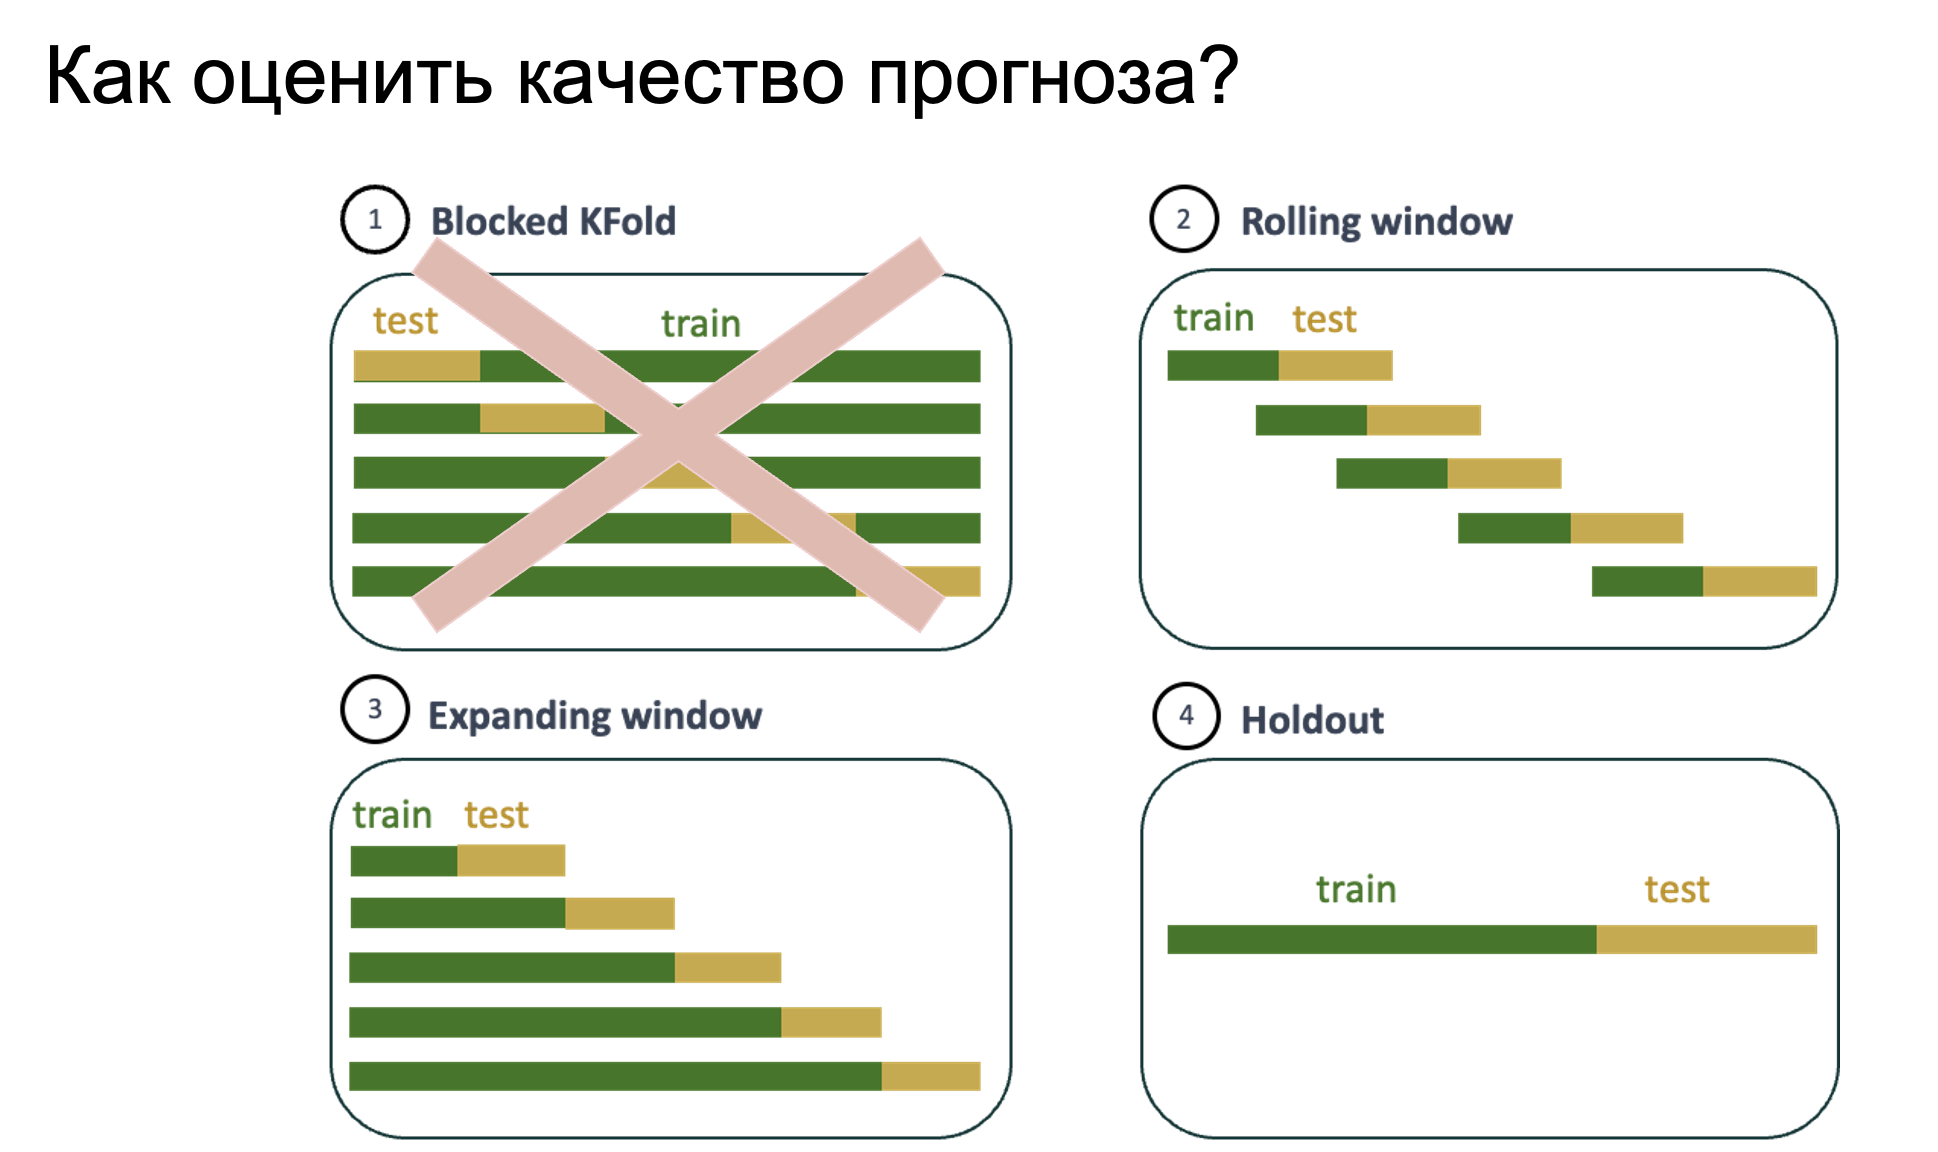

In [99]:
# Возьмем последние 60 точек каждого ряда как hold-out тест

def train_test_split_panel(
    df: pd.DataFrame,
    time_col: str = "ds",
    group_col: str = "series_id",
    holdout: int = 60,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.sort_values(by=[group_col, time_col])
    max_times = df.groupby(group_col)[time_col].max().reset_index()
    # одна и та же длина у всех + ряды выровнены — можно взять простую границу по дате
    cutoff = df[time_col].sort_values().unique()[-holdout]
    train = df[df[time_col] < cutoff].copy()
    test = df[df[time_col] >= cutoff].copy()
    return train, test

df_train, df_test = train_test_split_panel(df_feat, holdout=60)

df_train["ds"].min(), df_train["ds"].max(), df_test["ds"].min(), df_test["ds"].max()

(Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-08-27 00:00:00'),
 Timestamp('2020-08-28 00:00:00'),
 Timestamp('2020-10-26 00:00:00'))

In [100]:
df_train.head()

,series_id,ds,y,y_log,y_diff1,year,month,day,dow,weekofyear,...,y_roll_mean_7,y_roll_std_7,y_roll_mean_28,y_roll_std_28,dow7_sin_1,dow7_cos_1,dow7_sin_2,dow7_cos_2,dow7_sin_3,dow7_cos_3
0,0,2020-01-01,12.464150,NaN,NaN,2020,1,1,2,1,...,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0,2020-01-02,13.139250,3.119108,NaN,2020,1,2,3,1,...,12.464150,NaN,12.464150,NaN,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2,0,2020-01-03,14.660876,3.148509,0.675100,2020,1,3,4,1,...,12.801700,0.477368,12.801700,0.477368,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
3,0,2020-01-04,13.604389,3.211767,1.521625,2020,1,4,5,1,...,13.421425,1.125219,13.421425,1.125219,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
4,0,2020-01-05,9.178782,3.168274,-1.056486,2020,1,5,6,1,...,13.467166,0.923281,13.467166,0.923281,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


In [101]:
def make_time_series_splits(
    n_splits: int,
    test_size: int,
    expanding: bool = True,
) -> TimeSeriesSplit:
    """
    Обертка над TimeSeriesSplit:
    - expanding: train растет
    - rolling: train фиксированного размера
    """
    if expanding:
        return TimeSeriesSplit(
            n_splits=n_splits,
            test_size=test_size,
            max_train_size=None,
        )
    else:
        max_train_size = test_size * 3
        return TimeSeriesSplit(
            n_splits=n_splits,
            test_size=test_size,
            max_train_size=max_train_size,
        )


one_series = df_train[df_train["series_id"] == 0].sort_values(by="ds").reset_index(drop=True)
X_demo = np.arange(len(one_series)).reshape(-1, 1)

tscv_exp = make_time_series_splits(n_splits=4, test_size=10, expanding=True)
tscv_roll = make_time_series_splits(n_splits=4, test_size=10, expanding=False)

print("Expanding splits:")
for fold, (train_idx, test_idx) in enumerate(tscv_exp.split(X_demo)):
    print(
        f"Fold {fold}: Train indices {train_idx[:3]}...{train_idx[-3:]}, Val indices {test_idx[0]}...{test_idx[-1]}"
    )

print("\nRolling splits:")
for fold, (train_idx, test_idx) in enumerate(tscv_roll.split(X_demo)):
    print(
        f"Fold {fold}: Train indices {train_idx[:3]}...{train_idx[-3:]}, Val indices {test_idx[0]}...{test_idx[-1]}"
    )

Expanding splits:
Fold 0: Train indices [0 1 2]...[197 198 199], Val indices 200...209
Fold 1: Train indices [0 1 2]...[207 208 209], Val indices 210...219
Fold 2: Train indices [0 1 2]...[217 218 219], Val indices 220...229
Fold 3: Train indices [0 1 2]...[227 228 229], Val indices 230...239

Rolling splits:
Fold 0: Train indices [170 171 172]...[197 198 199], Val indices 200...209
Fold 1: Train indices [180 181 182]...[207 208 209], Val indices 210...219
Fold 2: Train indices [190 191 192]...[217 218 219], Val indices 220...229
Fold 3: Train indices [200 201 202]...[227 228 229], Val indices 230...239


## 5. Построение глобальной ML-модели для всех рядов сразу.

In [102]:
X_train = df_train.drop(columns=["y", "ds"])
y_train = df_train["y"]

X_test = df_test.drop(columns=["y", "ds"])
y_test = df_test["y"]

print("Проверим, что всё нормально:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("X_train:")
display(X_train.head())

print("y_train:")
display(y_train.head())

print("X_test:")
display(X_test.head())

print("y_test:")
display(y_test.head())

Проверим, что всё нормально:
X_train shape: (4800, 22), y_train shape: (4800,)
X_test shape: (1200, 22), y_test shape: (1200,)
X_train:


,series_id,y_log,y_diff1,year,month,day,dow,weekofyear,is_weekend,y_lag_1,...,y_roll_mean_7,y_roll_std_7,y_roll_mean_28,y_roll_std_28,dow7_sin_1,dow7_cos_1,dow7_sin_2,dow7_cos_2,dow7_sin_3,dow7_cos_3
0,0,NaN,NaN,2020,1,1,2,1,0,NaN,...,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0,3.119108,NaN,2020,1,2,3,1,0,12.464150,...,12.464150,NaN,12.464150,NaN,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2,0,3.148509,0.675100,2020,1,3,4,1,0,13.139250,...,12.801700,0.477368,12.801700,0.477368,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
3,0,3.211767,1.521625,2020,1,4,5,1,1,14.660876,...,13.421425,1.125219,13.421425,1.125219,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
4,0,3.168274,-1.056486,2020,1,5,6,1,1,13.604389,...,13.467166,0.923281,13.467166,0.923281,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521


y_train:


0    12.464150
1    13.139250
2    14.660876
3    13.604389
4     9.178782
Name: y, dtype: float64

X_test:


,series_id,y_log,y_diff1,year,month,day,dow,weekofyear,is_weekend,y_lag_1,...,y_roll_mean_7,y_roll_std_7,y_roll_mean_28,y_roll_std_28,dow7_sin_1,dow7_cos_1,dow7_sin_2,dow7_cos_2,dow7_sin_3,dow7_cos_3
240,0,3.040910,1.903234,2020,8,28,4,35,0,10.762233,...,8.027623,3.159624,8.951274,3.172099,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
241,0,3.095022,1.163453,2020,8,29,5,35,1,11.925686,...,8.114001,3.270969,8.852267,3.025992,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
242,0,3.144045,1.109786,2020,8,30,6,35,1,13.035472,...,8.430618,3.660526,8.898294,3.080950,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
243,0,2.759967,-7.398194,2020,8,31,0,36,0,5.637277,...,8.387674,3.696233,8.793750,3.141760,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
244,0,2.602945,-2.295869,2020,9,1,1,36,0,3.341408,...,8.295825,3.829476,8.749298,3.211530,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969


y_test:


240    11.925686
241    13.035472
242     5.637277
243     3.341408
244     7.147877
Name: y, dtype: float64

In [110]:
gbr = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
gbr.fit(X_train, y_train)

df_train["y_pred"] = gbr.predict(X_train)
df_test["y_pred"] = gbr.predict(X_test)

# Метрики качества на тесте
rmse = np.sqrt(mean_squared_error(y_test, df_test["y_pred"]))
mae = mean_absolute_error(y_test, df_test["y_pred"])

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, df_train["y_pred"])):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, df_train["y_pred"]):.4f}")

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Train RMSE: 0.8485
Train MAE: 0.6748
Test RMSE: 1.3064
Test MAE: 1.0395


Посмотрим на один конкретный ряд: истинные значения и прогноз ML-модели.

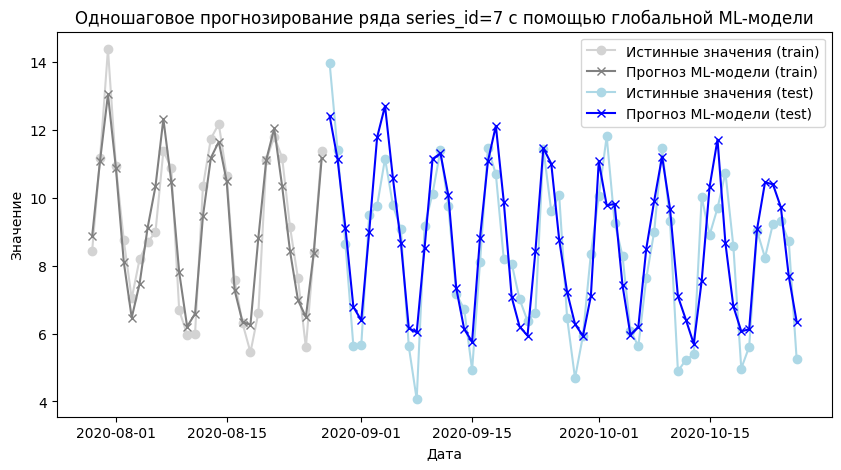

In [114]:
sample_id = sample_ids[0]
test_one = df_test[df_test["series_id"] == sample_id].sort_values(by="ds")

plt.figure(figsize=(10, 5))
plt.plot(
    df_train[df_train["series_id"] == sample_id]["ds"][-30:],
    df_train[df_train["series_id"] == sample_id]["y"][-30:],
    label="Истинные значения (train)",
    marker="o",
    color="lightgray",
)
plt.plot(
    df_train[df_train["series_id"] == sample_id]["ds"][-30:],
    df_train[df_train["series_id"] == sample_id]["y_pred"][-30:],
    label="Прогноз ML-модели (train)",
    marker="x",
    color="gray",
)
plt.plot(
    test_one["ds"],
    test_one["y"],
    label="Истинные значения (test)",
    marker="o",
    color="lightblue",
)
plt.plot(
    test_one["ds"],
    test_one["y_pred"],
    label="Прогноз ML-модели (test)",
    marker="x",
    color="blue",
)
plt.title(f"Одношаговое прогнозирование ряда series_id={sample_id} с помощью глобальной ML-модели")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.show()

Обратите внимание, что здесь мы прогнозируем ТОЛЬКО на одну точку вперед. Поэтому графики могут показаться ошибочно "красивыми". При многошаговом прогнозировании ошибки неизбежно будут накапливаться, и качество будет падать по мере продвижения по горизонту прогнозирования.